In [1]:
import pandas as pd

file_path = r"C:\Users\HR\Desktop\Workspace\데이터톤\마케팅\merged_data.csv"
df = pd.read_csv(file_path)

print(df.head())

                  event_time event_type  product_id          category_id  \
0  2019-10-01 00:00:00+00:00       cart     5773203  1487580005134238553   
1  2019-10-01 00:00:03+00:00       cart     5773353  1487580005134238553   
2  2019-10-01 00:00:07+00:00       cart     5881589  2151191071051219817   
3  2019-10-01 00:00:07+00:00       cart     5723490  1487580005134238553   
4  2019-10-01 00:00:15+00:00       cart     5881449  1487580013522845895   

    brand  price    user_id                          user_session  \
0  runail   2.62  463240011  26dd6e6e-4dac-4778-8d2c-92e149dab885   
1  runail   2.62  463240011  26dd6e6e-4dac-4778-8d2c-92e149dab885   
2  lovely  13.48  429681830  49e8d843-adf3-428b-a2c3-fe8bc6a307c9   
3  runail   2.62  463240011  26dd6e6e-4dac-4778-8d2c-92e149dab885   
4  lovely   0.56  429681830  49e8d843-adf3-428b-a2c3-fe8bc6a307c9   

           event_time_moscow  event_month  \
0  2019-10-01 03:00:00+03:00         10.0   
1  2019-10-01 03:00:03+03:00         1

In [2]:
import pandas as pd

# CSV 또는 Parquet 파일을 불러온 뒤 df에 저장했다고 가정
# 예: df = pd.read_csv('your_file.csv') 또는 pd.read_parquet('your_file.parquet')

#  1. price가 0인 행 제거
df = df[df['price'] > 0]

#  2. brand 컬럼에서 결측치 제거
df = df.dropna(subset=['brand'])

# 결과 확인 (선택사항)
print(df.shape)
print(df['price'].min())
print(df['brand'].isnull().sum())

(11932733, 11)
0.06
0


# Black Friday(11월)에 평균 구매 금액이 높다?

In [4]:
# 구매 이벤트만 필터링
df_purchase = df[df['event_type'] == 'purchase'].copy()

# 구매월 컬럼이 있다면 그대로 사용, 없으면 추출
df_purchase['purchase_month'] = pd.to_datetime(df_purchase['event_time_moscow']).dt.month


In [5]:
monthly_avg = df_purchase.groupby('purchase_month')['price'].mean().reset_index()


In [6]:
from scipy.stats import ttest_ind

# 11월과 나머지 비교
nov = df_purchase[df_purchase['purchase_month'] == 11]['price']
not_nov = df_purchase[df_purchase['purchase_month'] != 11]['price']

# 독립표본 t-test
t_stat, p_val = ttest_ind(nov, not_nov, equal_var=False)
print(f"📊 t 통계량: {t_stat:.4f}, p-value: {p_val:.4e}")


📊 t 통계량: -9.7605, p-value: 1.6749e-22


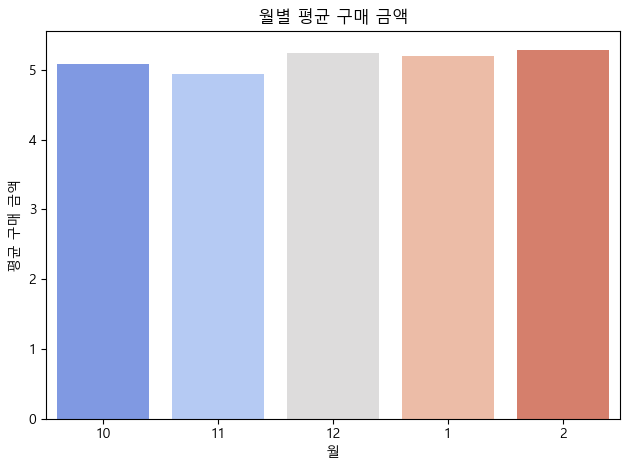

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# 구매 이벤트만 필터링
df_purchase = df[df['event_type'] == 'purchase']

# 월별 평균 구매 금액
month_avg = df_purchase.groupby('event_month')['price'].mean().reset_index()

# 정렬된 순서로 보기 위해 순서 지정
month_order = [10, 11, 12, 1, 2]

# 그래프
sns.barplot(x='event_month', y='price', data=month_avg, order=month_order, palette='coolwarm')
plt.title('월별 평균 구매 금액')
plt.xlabel('월')
plt.ylabel('평균 구매 금액')
plt.tight_layout()
plt.show()



# 분석 결과 요약
     시각화
    11월의 평균 구매 금액이 다른 월에 비해 가장 낮은 수준으로 보임
    10월, 12월, 1월, 2월 모두 11월보다 높은 평균 구매 금액

     t-검정 결과
    t 통계량: -9.7605, p-value: 1.6749e-22
    p-value가 매우 작음 ⇒ 귀무가설 기각
    즉, 11월은 통계적으로도 유의하게 평균 구매 금액이 낮음

# 결론 해석
    “11월(Black Friday 포함)의 평균 구매 금액은 다른 월에 비해 유의미하게 낮았습니다.”
    이는 소비자들이 11월에는 저가 상품을 많이 구매했을 가능성을 시사하며, 할인 행사 중심의 대량 소비 패턴과 맞물립니다

# 요일/시간대에 따라 구매 빈도 및 전환율 다르다?


In [18]:
import pandas as pd
from scipy.stats import f_oneway
import matplotlib.pyplot as plt
import seaborn as sns
import platform

# ✅ 한글 폰트 설정
if platform.system() == 'Windows':
    plt.rc('font', family='Malgun Gothic')
elif platform.system() == 'Darwin':
    plt.rc('font', family='AppleGothic')
else:
    plt.rc('font', family='NanumGothic')
plt.rcParams['axes.unicode_minus'] = False

# 1. 날짜 파싱 및 요일 생성
df['event_time'] = pd.to_datetime(df['event_time'])
df['weekday'] = df['event_time'].dt.day_name()  # 예: 'Monday'

# 2. 유저별 요일 기준 전환 여부 생성
view = df[df['event_type'] == 'view'][['user_key', 'weekday']].drop_duplicates()
purchase = df[df['event_type'] == 'purchase'][['user_key', 'weekday']].drop_duplicates()

merged = pd.merge(view, purchase, on=['user_key', 'weekday'], how='left', indicator=True)
merged['converted'] = (merged['_merge'] == 'both').astype(int)

# 3. 요일별 리스트로 변환 (0/1 리스트 형태)
grouped = merged.groupby('weekday')['converted'].apply(list)

# 4. ANOVA (일원분산분석)
f_stat, p_val = f_oneway(*grouped)
print(f"📊 F 통계량: {f_stat:.4f}, p-value: {p_val:.4e}")


📊 F 통계량: 30.5442, p-value: 6.8913e-37


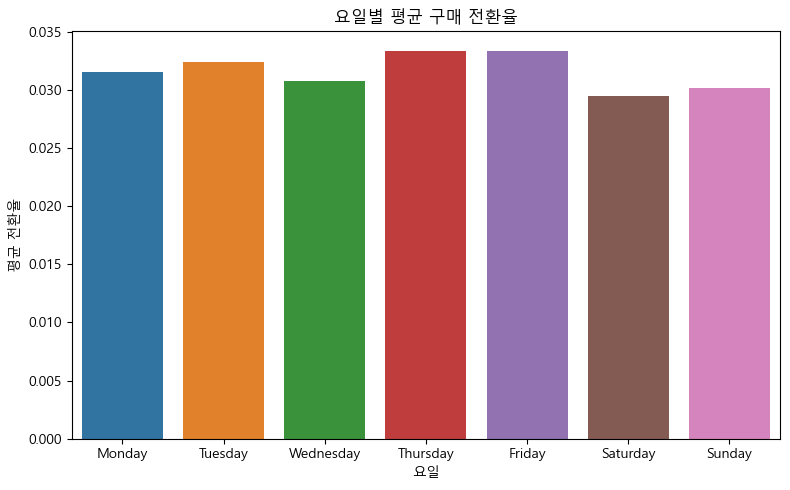

In [19]:
# 요일 정렬 순서 설정
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# 평균 전환율 계산
conversion_mean = merged.groupby('weekday')['converted'].mean().reindex(weekday_order)

# 시각화
plt.figure(figsize=(8, 5))
sns.barplot(x=conversion_mean.index, y=conversion_mean.values)
plt.title('요일별 평균 구매 전환율')
plt.xlabel('요일')
plt.ylabel('평균 전환율')
plt.tight_layout()
plt.show()


# 해석
        ANOVA 검정 결과
    F 통계량: 30.5442
    p-value: 6.8913e-37 (매우 작음)
    → p < 0.05이므로, 요일에 따라 전환율이 유의미하게 다르다는 통계적 증거가 있음.

    📈 그래프 해석
    전환율이 가장 높은 요일: Thursday ≈ Friday ≈ Tuesday
    전환율이 가장 낮은 요일: Saturday < Sunday
   → 주중(특히 화~금) 전환율이 높고, 주말엔 전환율이 낮은 경향.

       🧠 결론 요약
    요일별 구매 전환율에는 유의미한 차이가 있다 (대립가설 채택).
    마케팅 전략 수립 시, **주말보다는 평일(화~금)**에 더 적극적인 구매 유도가 효과적일 가능성 있음.

In [23]:
import pandas as pd
from scipy.stats import f_oneway
import matplotlib.pyplot as plt
import seaborn as sns

# 시간 추출
df['hour'] = pd.to_datetime(df['event_time']).dt.hour


In [24]:
# view / purchase 데이터 분리
view = df[df['event_type'] == 'view'][['user_key', 'hour']].drop_duplicates()
purchase = df[df['event_type'] == 'purchase'][['user_key', 'hour']].drop_duplicates()

# view 기준으로 purchase 여부 병합
merged_time = pd.merge(view, purchase, on=['user_key', 'hour'], how='left', indicator=True)
merged_time['converted'] = (merged_time['_merge'] == 'both').astype(int)


In [25]:
# 시간대별 전환율 리스트 생성
grouped_time = merged_time.groupby('hour')['converted'].apply(list)
f_stat_time, p_val_time = f_oneway(*grouped_time)

print(f"⏰ 시간대별 F 통계량: {f_stat_time:.4f}, p-value: {p_val_time:.4e}")


⏰ 시간대별 F 통계량: 32.5904, p-value: 1.6270e-143


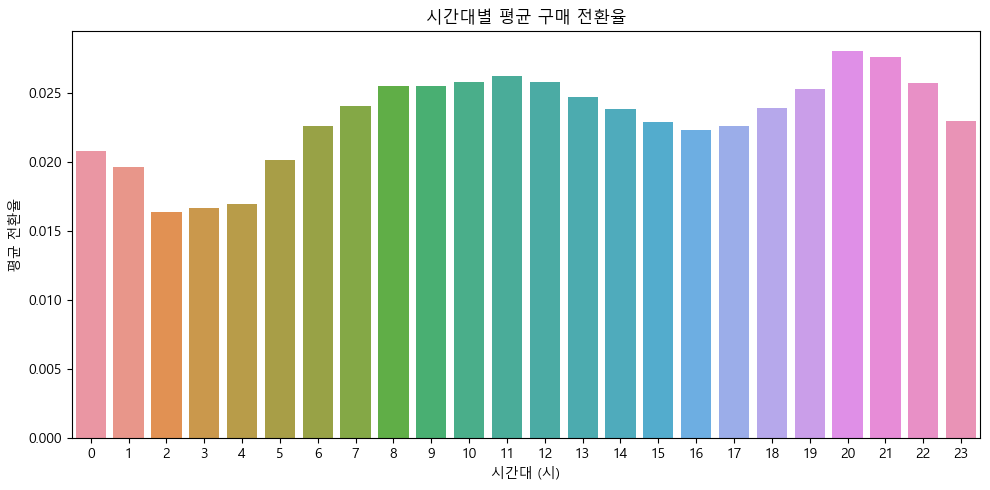

In [26]:
# 평균 전환율 계산
hour_conversion = merged_time.groupby('hour')['converted'].mean()

plt.figure(figsize=(10, 5))
sns.barplot(x=hour_conversion.index, y=hour_conversion.values)
plt.title('시간대별 평균 구매 전환율')
plt.xlabel('시간대 (시)')
plt.ylabel('평균 전환율')
plt.tight_layout()
plt.show()


# 결과
    F 통계량: 32.5904
    p-value: 1.6270e-143 (매우 유의미)

    🧠 해석
    p-value가 0.05보다 훨씬 작기 때문에, 귀무가설은 기각됨.
     즉, 시간대에 따라 구매 전환율은 통계적으로 유의미하게 다르다.
        
    📈 시각적 인사이트
    20시 ~ 22시에 가장 높은 전환율을 보임 → 저녁 시간대에 구매 전환 집중
    반면, 새벽 2시 ~ 5시 사이 전환율은 낮은 편 → 활동량 낮은 시간대

✅ 결론
"사용자의 구매 전환율은 시간대에 따라 통계적으로 유의미한 차이를 보이며, 특히 저녁 시간대(20~22시)에 집중되는 경향이 있다. 이를 기반으로 마케팅 타이밍을 최적화할 수 있다."

# 오후 8~12시 사이 전환율이 높다?

In [32]:
# 1. event_hour 컬럼 만들기
df['event_hour'] = pd.to_datetime(df['event_time']).dt.hour  # 또는 df['event_time_moscow']

# 2. 시간대별 구매 수 / view 수 계산
hourly_funnel = df.pivot_table(
    index='event_hour',
    columns='event_type',
    values='user_key',  # 또는 'user_id'
    aggfunc='nunique',
    fill_value=0
).reset_index()

# 3. 전환율 컬럼 생성
hourly_funnel['conversion_rate'] = hourly_funnel['purchase'] / hourly_funnel['view']
hourly_funnel = hourly_funnel.dropna(subset=['conversion_rate'])

# 4. t-test용 그룹 분리
from scipy.stats import ttest_ind

late_night = hourly_funnel[hourly_funnel['event_hour'].between(20, 23)]['conversion_rate']
others = hourly_funnel[~hourly_funnel['event_hour'].between(20, 23)]['conversion_rate']

# 5. 단측 t-test (late_night > others)
t_stat, p_value = ttest_ind(late_night, others, alternative='greater')

print(f"📊 t 통계량: {t_stat:.4f}, p-value: {p_value:.4e}")


📊 t 통계량: 1.0598, p-value: 1.5036e-01


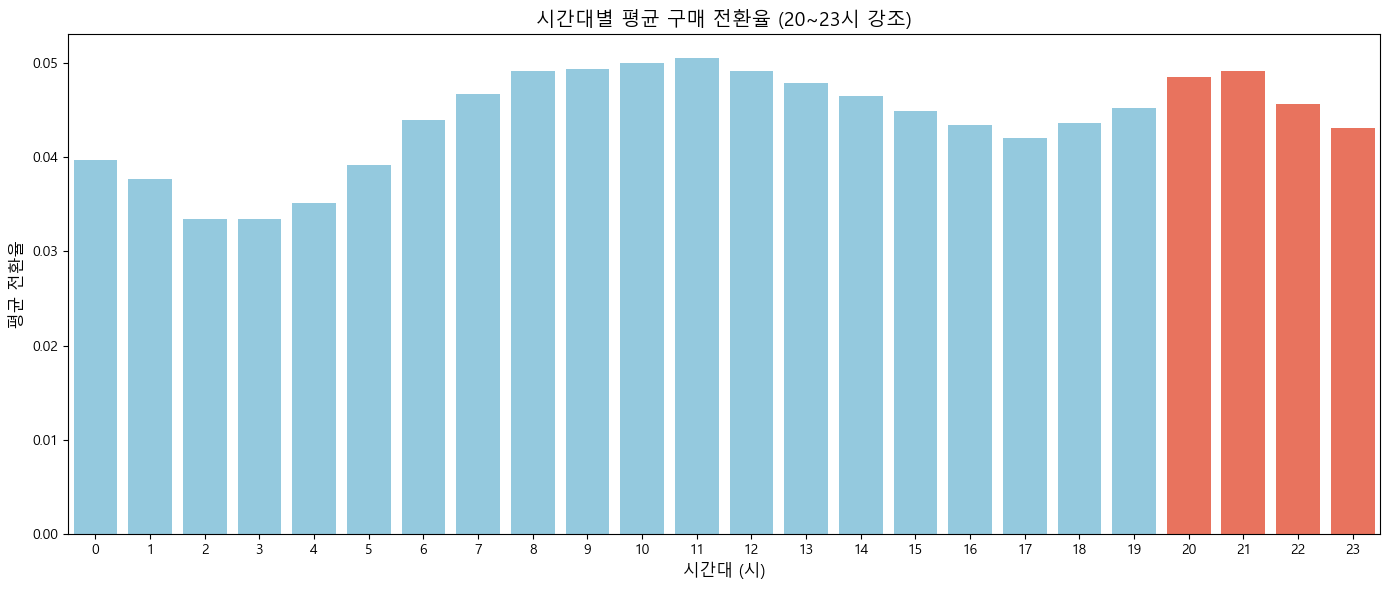

📊 t 통계량: 1.0598, p-value: 1.5036e-01


In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

# 📌 전처리: event_hour 추출
df['event_time'] = pd.to_datetime(df['event_time'])  # 또는 df['event_time_moscow']
df['event_hour'] = df['event_time'].dt.hour

# 📌 퍼널 계산 (시간대별 view, purchase 집계)
hourly_funnel = df.pivot_table(
    index='event_hour',
    columns='event_type',
    values='user_key',  # 또는 'user_id'
    aggfunc='nunique',
    fill_value=0
).reset_index()

# 📌 전환율 계산
hourly_funnel['conversion_rate'] = hourly_funnel['purchase'] / hourly_funnel['view']
hourly_funnel = hourly_funnel.dropna(subset=['conversion_rate'])

# ✅ 시각화: 시간대별 전환율
plt.figure(figsize=(14,6))
colors = ['tomato' if 20 <= h <= 23 else 'skyblue' for h in hourly_funnel['event_hour']]
sns.barplot(data=hourly_funnel, x='event_hour', y='conversion_rate', palette=colors)
plt.title("시간대별 평균 구매 전환율 (20~23시 강조)", fontsize=14)
plt.xlabel("시간대 (시)", fontsize=12)
plt.ylabel("평균 전환율", fontsize=12)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# ✅ 가설 검정: t-test (late night vs others)
late_night = hourly_funnel[hourly_funnel['event_hour'].between(20, 23)]['conversion_rate']
others = hourly_funnel[~hourly_funnel['event_hour'].between(20, 23)]['conversion_rate']

t_stat, p_value = ttest_ind(late_night, others, alternative='greater')

print(f"📊 t 통계량: {t_stat:.4f}, p-value: {p_value:.4e}")


# ✅ 가설 검정 요약
    가설 (단측 t-test)
    H₀ (귀무가설): 오후 8시11시(2023시)의 전환율은 다른 시간대와 차이가 없다
    H₁ (대립가설): 오후 8시11시(2023시)의 전환율이 다른 시간대보다 높다
    t 통계량: 1.0598
    p-value: 0.1504 (약 15%)

    📉 해석
    p-value > 0.05 → 유의수준 5% 기준에서는 통계적으로 유의미하지 않음
    따라서, "오후 8시~11시 사이의 전환율이 더 높다"는 증거는 부족함

    📊 시각적 인사이트
    그래프 상으로는 20시~21시 전환율이 비교적 높아 보이지만,
    전반적인 편차가 크지 않아 통계적으로 유의미한 차이로 보기 어렵다는 결론

    ✅ 결론 정리
    "오후 8시~11시 사이의 구매 전환율이 유의하게 높다"고 말할 수는 없습니다.
    시각적으로는 다소 높아 보일 수 있으나, 통계적으로는 유의한 차이가 아닙니다 (p = 0.15)

# 주말보다 평일에 구매가 많다?

In [47]:
from scipy.stats import ttest_ind
import pandas as pd

# 1. 구매 데이터 필터링
df_purchase = df[df['event_type'] == 'purchase'].copy()

# 2. 요일 추출 (0=월 ~ 6=일)
df_purchase['event_time'] = pd.to_datetime(df_purchase['event_time'])
df_purchase['weekday'] = df_purchase['event_time'].dt.dayofweek

# 3. 평일/주말 구분
weekday_purchases = df_purchase[df_purchase['weekday'] < 5]
weekend_purchases = df_purchase[df_purchase['weekday'] >= 5]

# 4. 날짜별 구매 수 계산
weekday_counts = weekday_purchases.groupby(weekday_purchases['event_time'].dt.date).size()
weekend_counts = weekend_purchases.groupby(weekend_purchases['event_time'].dt.date).size()

# 5. t-test (단측: 평일이 더 많은가?)
t_stat, p_value = ttest_ind(weekday_counts, weekend_counts, alternative='greater')

print(f"📊 t 통계량: {t_stat:.4f}, p-value: {p_value:.4e}")


📊 t 통계량: 2.6606, p-value: 4.3249e-03


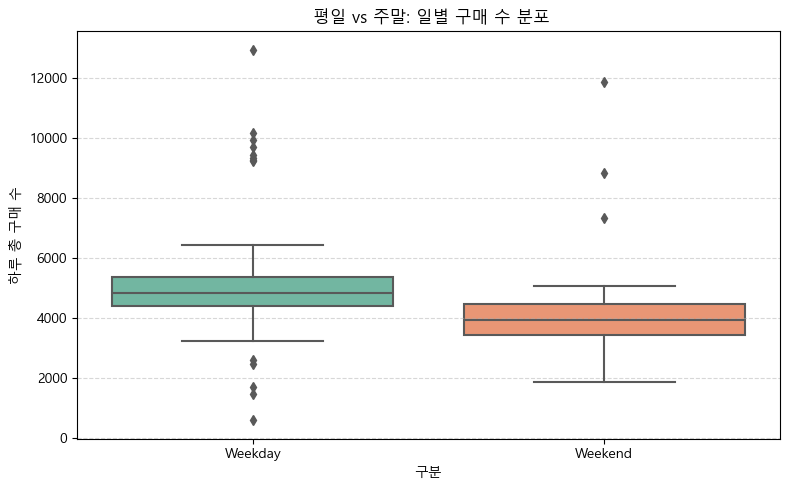

In [49]:
# 평일 데이터
weekday_df = weekday_counts.reset_index(drop=True)
weekday_df = pd.DataFrame({
    'date': weekday_counts.index,
    'purchase_count': weekday_counts.values,
    'type': 'Weekday'
})

# 주말 데이터
weekend_df = weekend_counts.reset_index(drop=True)
weekend_df = pd.DataFrame({
    'date': weekend_counts.index,
    'purchase_count': weekend_counts.values,
    'type': 'Weekend'
})

# 병합
combined = pd.concat([weekday_df, weekend_df], ignore_index=True)


import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.boxplot(data=combined, x='type', y='purchase_count', palette='Set2')
plt.title(" 평일 vs 주말: 일별 구매 수 분포")
plt.xlabel("구분")
plt.ylabel("하루 총 구매 수")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


 # 결과
     t 통계량: 2.6606
     p-value: 0.0043 (1% 유의수준에서도 유의함)

    📈 시각화
     Boxplot을 보면 평일의 중앙값(중앙선)이 주말보다 높음
     이상치는 있지만 전반적으로 평일 구매 수가 더 많은 경향이 확인됨

     ✅ 결론
     통계적으로 유의미하게 평일이 주말보다 더 많은 구매가 발생하고 있음.
     따라서 “주말보다 평일에 구매가 많다”는 가설은 채택할 수 있음.